In [1]:
!pip install -q transformers timm lime scikit-image opencv-python matplotlib pandas torch torchvision safetensors

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
# Célula 1: imports e configurações
import os
import sys
import unicodedata
import random
import shutil
import zipfile
from zipfile import ZipFile
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from PIL import Image, ImageFile
import cv2
from skimage.segmentation import slic
from lime import lime_image
from skimage.color import gray2rgb
import matplotlib.pyplot as plt
from tqdm import tqdm

ImageFile.LOAD_TRUNCATED_IMAGES = True

# Configurações (ajuste se necessário)
REPO_URL = 'https://github.com/JaoBezerra/Dataset-Expressoes-Faciais.git'
CLONE_DIR = '/content/Dataset-Expressoes-Faciais'
# Nome do zip do modelo no seu Google Drive (conforme você pediu)
MODEL_ZIP_DRIVE = '/content/drive/MyDrive/resultados_deit.zip'
MODEL_EXTRACT_DIR = '/content/meu_model'

# Extrair dataset zip para este diretório
DATA_EXTRACT_DIR = '/content/aplicaçãoXAI'

# Parâmetros LIME / execução
N_LIME_SAMPLES = 300  # reduzir para testes rápidos
SEGMENTS = 100
NUM_EXAMPLES_VISUAL = 20  # quantos exemplos visuais salvar

# ---------- NOVA CONSTANTE: máximo de imagens por classe ----------
MAX_PER_CLASS = 300      # <= 300 imagens por emoção
RANDOM_SEED = 42         # seed para reproducibilidade da amostragem
# -----------------------------------------------------------------

# Classes padrão (apenas para mapeamento; o script detecta pastas dinamicamente)
CLASS_NAMES = ['Angry','Disgust','Fear','Happy','Neutral','Sad','Surprised']
NUM_CLASSES = len(CLASS_NAMES)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('DEVICE =', DEVICE)

DEVICE = cuda


In [3]:
try:
    from google.colab import drive
    print('Google Colab detectado — montando Drive...')
    drive.mount('/content/drive', force_remount=False)
    print('Drive montado.')
except Exception:
    print('google.colab.drive não disponível — se estiver executando localmente ajuste MODEL_ZIP_DRIVE.')

# Verificar o arquivo do modelo no Drive
if not os.path.exists(MODEL_ZIP_DRIVE):
    raise FileNotFoundError(f"Arquivo do modelo não encontrado em: {MODEL_ZIP_DRIVE}")

# (Re)criar pasta de extração e extrair
shutil.rmtree(MODEL_EXTRACT_DIR, ignore_errors=True)
os.makedirs(MODEL_EXTRACT_DIR, exist_ok=True)
print('Extraindo modelo:', MODEL_ZIP_DRIVE, '->', MODEL_EXTRACT_DIR)
with ZipFile(MODEL_ZIP_DRIVE, 'r') as zf:
    zf.extractall(MODEL_EXTRACT_DIR)
print('Extração do modelo finalizada.')

# Função para localizar a pasta que contém config.json + *.safetensors
def find_model_folder(base_dir):
    for root, dirs, files in os.walk(base_dir):
        if 'config.json' in files and any(f.endswith('.safetensors') for f in files):
            return root
    # fallback: checar base_dir direto
    try:
        files = os.listdir(base_dir)
        if 'config.json' in files and any(f.endswith('.safetensors') for f in files):
            return base_dir
    except Exception:
        pass
    return None

MODEL_LOCAL_PATH = find_model_folder(MODEL_EXTRACT_DIR)
if MODEL_LOCAL_PATH is None:
    # tentar procurar config.json recursivamente (caso a estrutura seja diferente)
    matches = list(Path(MODEL_EXTRACT_DIR).rglob('config.json'))
    if len(matches) > 0:
        MODEL_LOCAL_PATH = str(matches[0].parent)

if MODEL_LOCAL_PATH is None:
    raise FileNotFoundError('Não encontrei uma pasta com config.json e model.safetensors dentro de ' + MODEL_EXTRACT_DIR)

print('Modelo detectado em:', MODEL_LOCAL_PATH)

Google Colab detectado — montando Drive...
Mounted at /content/drive
Drive montado.
Extraindo modelo: /content/drive/MyDrive/resultados_deit.zip -> /content/meu_model
Extração do modelo finalizada.
Modelo detectado em: /content/meu_model/resultados_deit/deit_fold_3/checkpoint-50170


In [4]:
# Célula 3: carregar modelo Hugging Face localmente
from transformers import AutoConfig, AutoImageProcessor, AutoModelForImageClassification

print('Carregando modelo Hugging Face (local)...')
model = AutoModelForImageClassification.from_pretrained(MODEL_LOCAL_PATH, local_files_only=True)
processor = None
try:
    processor = AutoImageProcessor.from_pretrained(MODEL_LOCAL_PATH, local_files_only=True)
    print('AutoImageProcessor carregado.')
except Exception:
    print('AutoImageProcessor não encontrado: será usado preprocess manual.')

model.to(DEVICE).eval()

# Definir preprocess_fn que aceita lista de np.uint8 HxWx3 e retorna dict (processor) ou tensor batch
import torchvision.transforms as T

def preprocess_fn(images_list):
    # images_list: lista de numpy arrays HxWx3 (RGB uint8)
    if processor is not None:
        inputs = processor(images_list, return_tensors='pt')
        return inputs
    else:
        tf = T.Compose([
            T.ToPILImage(),
            T.Resize((224,224)),
            T.ToTensor(),
            T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
        ])
        batch = torch.stack([tf(img) for img in images_list])
        return batch

print('Modelo e preprocess_fn prontos.')

Carregando modelo Hugging Face (local)...
AutoImageProcessor não encontrado: será usado preprocess manual.
Modelo e preprocess_fn prontos.


In [5]:
# Célula 4: clonar repo do dataset (se necessário) e localizar/extrair o ZIP "aplicaçãoXAI.zip"
# Clonar repositório se não existir
if not os.path.exists(CLONE_DIR):
    print('Clonando repositório do dataset...')
    try:
        !git clone {REPO_URL} {CLONE_DIR}
    except Exception as e:
        print('git clone falhou (talvez falta git no ambiente):', e)

# Procurar por um arquivo .zip cujo nome contenha algo como 'aplic' + 'xai' (normalizando acentos)
zip_candidates = []
for root, dirs, files in os.walk(CLONE_DIR):
    for f in files:
        if f.lower().endswith('.zip'):
            fn_norm = unicodedata.normalize('NFKD', f).encode('ASCII','ignore').decode().lower()
            if 'aplic' in fn_norm and 'xai' in fn_norm:
                zip_candidates.append(os.path.join(root, f))

print('Zips candidatos encontrados:', zip_candidates)
if len(zip_candidates) == 0:
    raise FileNotFoundError('Não achei nenhum ZIP com "aplic" + "xai" dentro de ' + CLONE_DIR)

zip_path = zip_candidates[0]
print('Usando zip do dataset:', zip_path)

# Extrair para DATA_EXTRACT_DIR
shutil.rmtree(DATA_EXTRACT_DIR, ignore_errors=True)
os.makedirs(DATA_EXTRACT_DIR, exist_ok=True)
with ZipFile(zip_path, 'r') as zf:
    zf.extractall(DATA_EXTRACT_DIR)
print('Dataset extraído para', DATA_EXTRACT_DIR)

DATA_ROOT = DATA_EXTRACT_DIR

Clonando repositório do dataset...
Cloning into '/content/Dataset-Expressoes-Faciais'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 18 (delta 4), reused 17 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (18/18), 4.84 KiB | 4.84 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Filtering content: 100% (2/2), 170.74 MiB | 28.94 MiB/s, done.
Zips candidatos encontrados: ['/content/Dataset-Expressoes-Faciais/aplicaçãoXAI.zip']
Usando zip do dataset: /content/Dataset-Expressoes-Faciais/aplicaçãoXAI.zip
Dataset extraído para /content/aplicaçãoXAI


Total imagens encontradas em DATA_ROOT: 11154


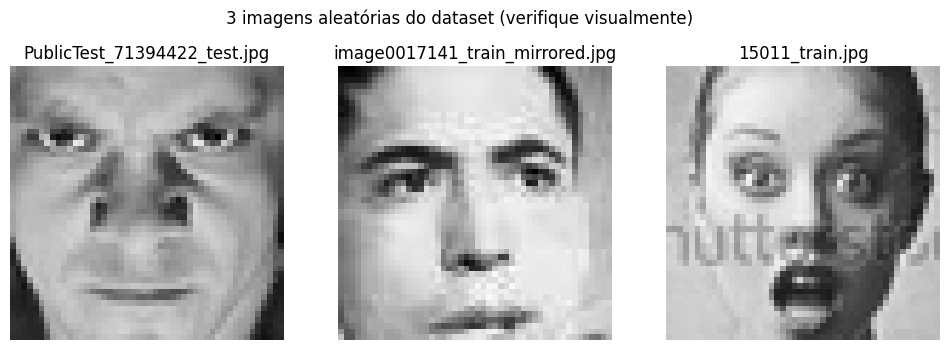

In [6]:
# Célula 5: listar imagens e mostrar 3 aleatórias (verificação)
all_images = []
for root, _, files in os.walk(DATA_ROOT):
    for f in files:
        if f.lower().endswith(('.png','.jpg','.jpeg','.bmp')):
            all_images.append(os.path.join(root, f))

print('Total imagens encontradas em DATA_ROOT:', len(all_images))
if len(all_images) == 0:
    raise RuntimeError('Nenhuma imagem encontrada em DATA_ROOT=' + DATA_ROOT)

# mostrar 3 imagens aleatórias
sample3 = random.sample(all_images, min(3, len(all_images)))
plt.figure(figsize=(12,4))
for i,p in enumerate(sample3):
    ax = plt.subplot(1,3,i+1)
    img = Image.open(p).convert('RGB')
    plt.imshow(img)
    plt.title(os.path.basename(p))
    plt.axis('off')
plt.suptitle('3 imagens aleatórias do dataset (verifique visualmente)')
plt.show()

In [7]:
# Célula 6: Função de classificação robusta para LIME

def classifier_fn_for_lime(images_list):
    """Recebe lista de HxWx3 uint8 (ou PIL images) e retorna np.array (N, num_classes) de probabilidades."""
    model.eval()
    imgs = []
    for im in images_list:
        if isinstance(im, Image.Image):
            arr = np.array(im.convert('RGB'))
        else:
            arr = np.array(im)
            if arr.ndim == 2:
                arr = gray2rgb(arr)
            if arr.shape[2] == 4:
                arr = arr[:,:,:3]
        imgs.append(arr)

    pre = preprocess_fn(imgs)
    # processor -> dict
    if isinstance(pre, dict):
        # mover tensores para device
        for k,v in pre.items():
            if isinstance(v, torch.Tensor):
                pre[k] = v.to(DEVICE)
        with torch.no_grad():
            outputs = model(**pre)
            logits = outputs.logits if hasattr(outputs, 'logits') else outputs
            if isinstance(logits, (tuple, list)):
                logits = logits[0]
            probs = F.softmax(logits, dim=-1).cpu().numpy()
        return probs

    # tensor batch
    if isinstance(pre, torch.Tensor):
        batch = pre.to(DEVICE)
        with torch.no_grad():
            outputs = model(batch)
            logits = outputs.logits if hasattr(outputs, 'logits') else outputs
            if isinstance(logits, (tuple, list)):
                logits = logits[0]
            probs = F.softmax(logits, dim=-1).cpu().numpy()
        return probs

    # fallback: aplicar transform manualmente
    tf = T.Compose([
        T.ToPILImage(),
        T.Resize((224,224)),
        T.ToTensor(),
        T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
    ])
    batch = torch.stack([tf(Image.fromarray(x)) for x in imgs]).to(DEVICE)
    with torch.no_grad():
        outputs = model(batch)
        logits = outputs.logits if hasattr(outputs, 'logits') else outputs
        if isinstance(logits, (tuple, list)):
            logits = logits[0]
        probs = F.softmax(logits, dim=-1).cpu().numpy()
    return probs

# teste de sanidade rápido
try:
    test_img = np.array(Image.open(all_images[0]).convert('RGB'))
    p = classifier_fn_for_lime([test_img])
    print('Sanity-check classifier -> probs shape:', p.shape)
except Exception as e:
    print('Falha no sanity-check do classificador:', e)

Sanity-check classifier -> probs shape: (1, 7)


In [8]:
# Célula 7: funções de detecção de face e máscaras de regiões
cascade_path = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
face_cascade = cv2.CascadeClassifier(cascade_path)


def detect_face_box(img_rgb):
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=3)
    if len(faces) == 0:
        return None
    faces = sorted(faces, key=lambda r: r[2]*r[3], reverse=True)
    return faces[0]


def compute_region_masks(image_shape, face_box=None):
    H,W = image_shape[:2]
    mask_mouth = np.zeros((H,W), dtype=bool)
    mask_eyes = np.zeros((H,W), dtype=bool)
    mask_forehead = np.zeros((H,W), dtype=bool)

    if face_box is None:
        # fallback: dividir em faixas verticais
        y1 = 0
        y2 = int(0.25*H)
        y3 = int(0.25*H)
        y4 = int(0.55*H)
        y5 = int(0.55*H)
        y6 = H
        mask_forehead[y1:y2,:] = True
        mask_eyes[y3:y4,:] = True
        mask_mouth[y5:y6,:] = True
    else:
        x,y,w,h = face_box
        x1,x2 = max(0,x), min(W, x+w)
        y1,y2 = max(0,y), min(H, y+h)
        fh = h
        fy1 = y1
        fy2 = y1 + int(0.25*fh)
        ey1 = fy2
        ey2 = y1 + int(0.55*fh)
        my1 = ey2
        my2 = y2
        mask_forehead[fy1:fy2, x1:x2] = True
        mask_eyes[ey1:ey2, x1:x2] = True
        mask_mouth[my1:my2, x1:x2] = True

    return mask_mouth, mask_eyes, mask_forehead

In [9]:
!pip install shap

In [9]:
# Funções de Análise Modulares

# Análise LIME
def run_lime_analysis(image_arr, explainer, classifier_fn, masks):
    """
    Roda UMA análise LIME em UMA imagem e retorna os percentuais.
    """
    mask_mouth, mask_eyes, mask_forehead = masks

    try:
        # Gerar explicação LIME
        explanation = explainer.explain_instance(
            image_arr,
            classifier_fn,
            top_labels=1,
            hide_color=0,
            num_samples=N_LIME_SAMPLES,
            segmentation_fn=lambda x: slic(x, n_segments=SEGMENTS, compactness=10, sigma=1)
        )

        # Obter o rótulo previsto
        top_label = None
        if hasattr(explanation, 'top_labels') and len(explanation.top_labels) > 0:
            top_label = int(explanation.top_labels[0])
        else:
            probs = classifier_fn([image_arr])[0]
            top_label = int(np.argmax(probs))

        # Agregar pesos por máscara (lógica da Célula 8)
        seg = explanation.segments
        local_map = explanation.local_exp.get(top_label, [])

        mouth_w, eyes_w, fore_w = 0.0, 0.0, 0.0
        for sp_id, weight in local_map:
            w = abs(weight)
            mask_sp = (seg == sp_id)
            cnt_mouth = int((mask_sp & mask_mouth).sum())
            cnt_eyes = int((mask_sp & mask_eyes).sum())
            cnt_fore = int((mask_sp & mask_forehead).sum())
            counts = [cnt_mouth, cnt_eyes, cnt_fore]
            if sum(counts) == 0: continue

            max_idx = int(np.argmax(counts))
            if max_idx == 0: mouth_w += w
            elif max_idx == 1: eyes_w += w
            else: fore_w += w

        total_w = mouth_w + eyes_w + fore_w
        if total_w > 0:
            return {
                "lime_mouth_pct": mouth_w / total_w,
                "lime_eyes_pct": eyes_w / total_w,
                "lime_forehead_pct": fore_w / total_w,
                "lime_error": None
            }
        else:
            return {"lime_mouth_pct": 0, "lime_eyes_pct": 0, "lime_forehead_pct": 0, "lime_error": "total_w_zero"}

    except Exception as e:
        return {"lime_mouth_pct": np.nan, "lime_eyes_pct": np.nan, "lime_forehead_pct": np.nan, "lime_error": str(e)}

# Análise SHAP (Nova)

import shap
import torch.nn.functional as F

def run_shap_partition_analysis(image_arr, pred_label_id, explainer_shap, masks):
    """
    Roda UMA análise SHAP (Partition) em UMA imagem e retorna os percentuais.
    'image_arr' DEVE ter 224x224x3
    """
    mask_mouth, mask_eyes, mask_forehead = masks

    try:
        # Gerar valores SHAP (com batch)
        shap_values = explainer_shap(np.expand_dims(image_arr, axis=0), max_evals=300, batch_size=50)

        # Pegar os SHAP values para a classe prevista
        heatmap = np.abs(shap_values.values[0][..., pred_label_id]).sum(axis=-1)

        # Normalizar mapa de calor
        heatmap_min, heatmap_max = heatmap.min(), heatmap.max()
        if heatmap_max - heatmap_min > 1e-6:
            heatmap = (heatmap - heatmap_min) / (heatmap_max - heatmap_min)

        # Agregar pesos (pixels) por máscara
        mouth_w = (heatmap[mask_mouth]).sum()
        eyes_w = (heatmap[mask_eyes]).sum()
        fore_w = (heatmap[mask_forehead]).sum()

        total_w = mouth_w + eyes_w + fore_w
        if total_w > 0:
            return {
                "shap_mouth_pct": mouth_w / total_w,
                "shap_eyes_pct": eyes_w / total_w,
                "shap_forehead_pct": fore_w / total_w,
                "shap_error": None
            }
        else:
            return {"shap_mouth_pct": 0, "shap_eyes_pct": 0, "shap_forehead_pct": 0, "shap_error": "total_w_zero"}

    except Exception as e:
        return {"shap_mouth_pct": np.nan, "shap_eyes_pct": np.nan, "shap_forehead_pct": np.nan, "shap_error": str(e)}

print("Funções de análise modulares definidas (LIME, SHAP-Partition).")

Funções de análise modulares definidas (LIME, SHAP-Partition).


In [27]:
# Agente BDI

from tqdm import tqdm
import pandas as pd
import shap
import torch
import torch.nn.functional as F
from PIL import Image
import numpy as np
import random
import os
import time
from collections import defaultdict, Counter

# CONFIG
MAX_PER_CLASS = 300
RANDOM_SEED = 42
TARGET_SIZE = (224, 224)
N_LIME_SAMPLES = 300
SEGMENTS = 100
SHAP_MAX_EVALS = 300
SHAP_BATCH_SIZE = 50
OUTPUT_CSV = '/content/bdi_analysis_results_VETORIAL_v3.csv'

# CRENÇAS (VETORIAL)
# As crenças agora são vetores (distribuição de importância esperada)
# Os pesos devem somar 1.0
CRENCAS_VETOR = {
    "angry":    {'mouth': 0.1, 'eyes': 0.6, 'forehead': 0.3},
    "disgust":  {'mouth': 0.7, 'eyes': 0.2, 'forehead': 0.1},
    "fear":     {'mouth': 0.1, 'eyes': 0.7, 'forehead': 0.2},
    "happy":    {'mouth': 0.7, 'eyes': 0.3, 'forehead': 0.0},
    "sad":      {'mouth': 0.1, 'eyes': 0.5, 'forehead': 0.4},
    "surprise": {'mouth': 0.4, 'eyes': 0.4, 'forehead': 0.2},
    "neutral":  {'mouth': 0.33, 'eyes': 0.33, 'forehead': 0.34} # Foco indefinido
}
print("CRENÇAS VETORIAIS carregadas (BDI 3.0):")

# HELPERS
def safe_expand_batch(x):
    a = np.asarray(x)
    if a.ndim == 3: return np.expand_dims(a, axis=0)
    return a

def normalize_map(m):
    m = np.asarray(m, dtype=float)
    if m.size == 0: return m
    mn, mx = m.min(), m.max()
    if mx - mn <= 1e-8: return np.zeros_like(m)
    return (m - mn) / (mx - mn)

def cosine_similarity(v1, v2):
    """Calcula a similaridade de cosseno entre dois vetores."""
    v1 = np.asarray(v1)
    v2 = np.asarray(v2)
    eps = 1e-8
    num = np.dot(v1, v2)
    den = (np.linalg.norm(v1) * np.linalg.norm(v2)) + eps
    return float(num / den)

def calculate_vectors_and_dominant(lime_record, shap_record):
    """
    Retorna o vetor de foco observado (média LIME+SHAP)
    e a região dominante (string).
    """
    # Calcular o vetor observado (média dos pcts)
    mouth = np.nanmean([lime_record.get('lime_mouth_pct', 0), shap_record.get('shap_mouth_pct', 0)])
    eyes  = np.nanmean([lime_record.get('lime_eyes_pct', 0),  shap_record.get('shap_eyes_pct', 0)])
    fore  = np.nanmean([lime_record.get('lime_forehead_pct', 0), shap_record.get('shap_forehead_pct', 0)])

    # Garantir que soma 1 (normalizar)
    total = mouth + eyes + fore
    if total > 0:
        mouth, eyes, fore = mouth/total, eyes/total, fore/total

    # Encontrar o dominante (para a coluna string)
    vals = {'focar_boca': mouth, 'focar_olhos': eyes, 'focar_testa': fore}
    dominant_str = max(vals, key=vals.get)

    return {'mouth': mouth, 'eyes': eyes, 'forehead': fore}, dominant_str

def slic_wrapper(x, n_segments=100):
    try:
        from skimage.segmentation import slic
        return slic(x, n_segments=n_segments, compactness=10, sigma=1)
    except Exception:
        H, W = x.shape[:2]; seg = np.zeros((H, W), dtype=int); bh = max(1, H // int(np.sqrt(n_segments))); bw = max(1, W // int(np.sqrt(n_segments))); idx = 0
        for i in range(0, H, bh):
            for j in range(0, W, bw): seg[i:i+bh, j:j+bw] = idx; idx += 1
        return seg

# BDI AGENT CLASS
class AgenteBDI:
    def __init__(self, crencas_vetor_init, lime_explainer, explainer_shap, classifier_fn, class_names):
        self.crencas_vetor = crencas_vetor_init
        self.lime_explainer = lime_explainer
        self.explainer_shap = explainer_shap
        self.classifier_fn = classifier_fn
        self.class_names = class_names
        self.memoria = []

    def classifier_function_wrapper(self, images_list):
        return self.classifier_fn(images_list)

    def run_lime(self, image_arr, masks):
        """
        Roda UMA análise LIME em UMA imagem e retorna os percentuais.
        (Versão COMPLETA e CORRIGIDA)
        """
        from lime import lime_image
        mask_mouth, mask_eyes, mask_forehead = masks

        try:
            arr = np.asarray(image_arr)
            # Gerar explicação LIME
            explanation = self.lime_explainer.explain_instance(
                arr,
                self.classifier_function_wrapper,
                top_labels=1,
                hide_color=0,
                num_samples=N_LIME_SAMPLES,
                segmentation_fn=lambda x: slic_wrapper(x, n_segments=SEGMENTS)
            )

            # Obter o rótulo previsto
            top_label = None
            if hasattr(explanation, 'top_labels') and len(explanation.top_labels) > 0:
                top_label = int(explanation.top_labels[0])
            else:
                probs = self.classifier_function_wrapper([arr])[0]
                top_label = int(np.argmax(probs))

            # Agregar pesos por máscara
            seg = explanation.segments
            local_map = explanation.local_exp.get(top_label, [])
            mouth_w, eyes_w, fore_w = 0.0, 0.0, 0.0
            for sp_id, weight in local_map:
                w = abs(weight)
                mask_sp = (seg == sp_id)
                cnts = [int((mask_sp & masks[0]).sum()), int((mask_sp & masks[1]).sum()), int((mask_sp & masks[2]).sum())]
                if sum(cnts) == 0: continue
                max_idx = int(np.argmax(cnts))
                if max_idx == 0: mouth_w += w
                elif max_idx == 1: eyes_w += w
                else: fore_w += w

            total = mouth_w + eyes_w + fore_w
            if total > 0:
                return {'lime_mouth_pct': mouth_w/total, 'lime_eyes_pct': eyes_w/total, 'lime_forehead_pct': fore_w/total, 'lime_error': None, 'lime_map': None}
            else:
                return {'lime_mouth_pct': 0, 'lime_eyes_pct': 0, 'lime_forehead_pct': 0, 'lime_error': 'total_w_zero', 'lime_map': None}
        except Exception as e:
            return {'lime_mouth_pct': np.nan, 'lime_eyes_pct': np.nan, 'lime_forehead_pct': np.nan, 'lime_error': str(e), 'lime_map': None}


    def run_shap(self, image_arr, pred_label_id, masks):
        """
        Roda UMA análise SHAP (Partition) em UMA imagem e retorna os percentuais.
        (Versão COMPLETA e CORRIGIDA)
        """
        mask_mouth, mask_eyes, mask_forehead = masks

        try:
            arr_batch = safe_expand_batch(image_arr)
            shap_values = self.explainer_shap(arr_batch, max_evals=SHAP_MAX_EVALS, batch_size=SHAP_BATCH_SIZE)
            vals = None

            if hasattr(shap_values, 'values'): vals = shap_values.values
            elif hasattr(shap_values, 'data'): vals = shap_values.data
            else: vals = shap_values

            # Pega os dados do batch (índice 0)
            heat = np.abs(vals[0][..., pred_label_id]).sum(axis=-1)

            heat_n = normalize_map(heat)
            mouth_w = heat_n[masks[0]].sum()
            eyes_w  = heat_n[masks[1]].sum()
            fore_w  = heat_n[masks[2]].sum()
            total = mouth_w + eyes_w + fore_w

            if total > 0:
                return {'shap_mouth_pct': mouth_w/total, 'shap_eyes_pct': eyes_w/total, 'shap_forehead_pct': fore_w/total, 'shap_error': None, 'shap_map': heat_n}
            else:
                return {'shap_mouth_pct': 0, 'shap_eyes_pct': 0, 'shap_forehead_pct': 0, 'shap_error': 'total_w_zero', 'shap_map': heat_n}
        except Exception as e:
            return {'shap_mouth_pct': np.nan, 'shap_eyes_pct': np.nan, 'shap_forehead_pct': np.nan, 'shap_error': str(e), 'shap_map': None}

    def record_and_update(self, img_path, true_label_dir, pred_label_name, res_lime, res_shap):

        # Calcular o "vetor observado" (média LIME+SHAP) e o foco dominante
        obs_vector, foco_obs_str = calculate_vectors_and_dominant(res_lime, res_shap)

        # Obter o "vetor de crença"
        pred_label_lower = pred_label_name.lower().strip()
        crenca_vector = self.crencas_vetor.get(pred_label_lower, CRENCAS_VETOR['neutral'])

        # Calcular o "Alinhamento Relativo" (Score de 0 a 1)
        v_obs = [obs_vector['mouth'], obs_vector['eyes'], obs_vector['forehead']]
        v_cre = [crenca_vector['mouth'], crenca_vector['eyes'], crenca_vector['forehead']]
        alinhamento_score = cosine_similarity(v_obs, v_cre)

        rec = {
            'path': img_path,
            'true_label_dir': true_label_dir,
            'pred_label_name': pred_label_name,
            'bdi_alinhamento_score': alinhamento_score,
            'foco_observado_str': foco_obs_str,
            'obs_mouth_pct': v_obs[0],
            'obs_eyes_pct': v_obs[1],
            'obs_forehead_pct': v_obs[2],
            'crenca_mouth_pct': v_cre[0],
            'crenca_eyes_pct': v_cre[1],
            'crenca_forehead_pct': v_cre[2],
            'lime_mouth_pct': res_lime.get('lime_mouth_pct'),
            'lime_eyes_pct': res_lime.get('lime_eyes_pct'),
            'lime_forehead_pct': res_lime.get('lime_forehead_pct'),
            'lime_error': res_lime.get('lime_error'),
            'shap_mouth_pct': res_shap.get('shap_mouth_pct'),
            'shap_eyes_pct': res_shap.get('shap_eyes_pct'),
            'shap_forehead_pct': res_shap.get('shap_forehead_pct'),
            'shap_error': res_shap.get('shap_error'),
            'pred_match_true': int(pred_label_name == true_label_dir)
        }

        self.memoria.append(rec)
        return rec

    def export_results(self, path=OUTPUT_CSV):
        df = pd.DataFrame.from_records(self.memoria)
        df.to_csv(path, index=False)
        return df

# SCRIPT PRINCIPAL
def run_bdi_agent_loop(DATA_ROOT,
                       classifier_fn_for_lime,
                       detect_face_box,
                       compute_region_masks,
                       CLASS_NAMES,
                       CRENCAS_VETOR_INIT):

    # (Amostragem de dados)
    random.seed(RANDOM_SEED)
    classes_dirs = sorted([d for d in os.listdir(DATA_ROOT) if os.path.isdir(os.path.join(DATA_ROOT, d))])
    sampled_class_imgs = {}; total_selected = 0
    for cls in classes_dirs:
        cls_path = os.path.join(DATA_ROOT, cls); imgs_all = sorted([os.path.join(cls_path, f) for f in os.listdir(cls_path) if f.lower().endswith(('.jpg','.jpeg','.png','.bmp'))]); n_total = len(imgs_all)
        if n_total == 0: sampled = []
        elif n_total <= MAX_PER_CLASS: sampled = imgs_all
        else: sampled = random.sample(imgs_all, MAX_PER_CLASS); sampled.sort()
        sampled_class_imgs[cls] = sampled; total_selected += len(sampled)
        print(f'Classe "{cls}": {n_total} imgs -> usando {len(sampled)}')
    print(f'Total imagens para processamento: {total_selected}')

    # (Inicializa LIME)
    from lime import lime_image
    lime_explainer = lime_image.LimeImageExplainer()
    print('Explicador LIME inicializado.')

    background_data = [np.zeros((TARGET_SIZE[0], TARGET_SIZE[1], 3), dtype=np.uint8)]
    masker_shap = shap.maskers.Image("inpaint_telea", background_data[0].shape)

    explainer_shap = shap.Explainer(classifier_fn_for_lime, masker_shap)
    print('Explicador SHAP (Explainer c/ Partition) inicializado.')

    # (Cria agente)
    agent = AgenteBDI(CRENCAS_VETOR_INIT, lime_explainer, explainer_shap, classifier_fn_for_lime, CLASS_NAMES)

    final_records = []
    for cls in classes_dirs:
        imgs_paths = sampled_class_imgs.get(cls, [])
        if len(imgs_paths) == 0: continue

        for img_path in tqdm(imgs_paths, desc=f'BDI Analisando {cls}'):
            try:
                img_pil_original = Image.open(img_path).convert('RGB')
                img_pil_224 = img_pil_original.resize(TARGET_SIZE, Image.LANCZOS)
                img_arr_224 = np.array(img_pil_224)

                face_box = detect_face_box(img_arr_224)
                masks = compute_region_masks(img_arr_224.shape, face_box)

                probs = classifier_fn_for_lime([img_arr_224])[0]
                pred_label_id = int(np.argmax(probs))
                pred_label_name = CLASS_NAMES[pred_label_id]

                # AÇÃO DO BDI
                res_lime = agent.run_lime(img_arr_224, masks)
                res_shap = agent.run_shap(img_arr_224, pred_label_id, masks)

                # REGISTRO DO BDI
                rec = agent.record_and_update(img_path, cls, pred_label_name, res_lime, res_shap)
                final_records.append(rec)

            except Exception as e:
                print(f'Erro fatal no loop principal para {img_path}: {e}')

    df = agent.export_results()
    print('Análise BDI concluída. Resultados:')
    df_grouped_head = df.groupby('true_label_dir').head(2)
    display(df_grouped_head)
    print(f'Resultados salvos em: {OUTPUT_CSV}')
    return agent, df

# RODA O AGENTE
agent, df = run_bdi_agent_loop(
    DATA_ROOT,
    classifier_fn_for_lime,
    detect_face_box,
    compute_region_masks,
    CLASS_NAMES,
    CRENCAS_VETOR
)

CRENÇAS VETORIAIS carregadas (BDI 3.0):
{'angry': {'mouth': 0.1, 'eyes': 0.6, 'forehead': 0.3}, 'disgust': {'mouth': 0.7, 'eyes': 0.2, 'forehead': 0.1}, 'fear': {'mouth': 0.1, 'eyes': 0.7, 'forehead': 0.2}, 'happy': {'mouth': 0.7, 'eyes': 0.3, 'forehead': 0.0}, 'sad': {'mouth': 0.1, 'eyes': 0.5, 'forehead': 0.4}, 'surprise': {'mouth': 0.4, 'eyes': 0.4, 'forehead': 0.2}, 'neutral': {'mouth': 0.33, 'eyes': 0.33, 'forehead': 0.34}}
Classe "angry": 1601 imgs -> usando 1
Classe "disgust": 1548 imgs -> usando 1
Classe "fear": 1601 imgs -> usando 1
Classe "happy": 1601 imgs -> usando 1
Classe "neutral": 1601 imgs -> usando 1
Classe "sad": 1601 imgs -> usando 1
Classe "surprise": 1601 imgs -> usando 1
Total imagens para processamento: 7
Explicador LIME inicializado.
Explicador SHAP (Explainer c/ Partition) inicializado.


BDI Analisando angry:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]


PartitionExplainer explainer: 2it [00:13, 13.43s/it]               
BDI Analisando disgust:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]


PartitionExplainer explainer: 2it [00:15, 15.57s/it]               
BDI Analisando fear:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]


PartitionExplainer explainer: 2it [00:13, 13.28s/it]               
BDI Analisando happy:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]


PartitionExplainer explainer: 2it [00:15, 15.36s/it]               
BDI Analisando neutral:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]


PartitionExplainer explainer: 2it [00:14, 14.62s/it]               
BDI Analisando sad:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]


PartitionExplainer explainer: 2it [00:13, 13.21s/it]               
BDI Analisando surprise:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]


PartitionExplainer explainer: 2it [00:14, 14.55s/it]               
BDI Analisando surprise: 100%|██████████| 1/1 [00:19<00:00, 19.61s/it]

Análise BDI concluída. Resultados:


,path,true_label_dir,pred_label_name,bdi_alinhamento_score,foco_observado_str,obs_mouth_pct,obs_eyes_pct,obs_forehead_pct,crenca_mouth_pct,crenca_eyes_pct,crenca_forehead_pct,lime_mouth_pct,lime_eyes_pct,lime_forehead_pct,lime_error,shap_mouth_pct,shap_eyes_pct,shap_forehead_pct,shap_error,pred_match_true
0,/content/aplicaçãoXAI/angry/image0015587_train...,angry,Fear,0.754724,focar_boca,0.453464,0.368100,0.178435,0.10,0.70,0.20,0.461430,0.309019,0.229551,None,0.445498,0.427181,0.127320,None,0
1,/content/aplicaçãoXAI/disgust/9023_train_vflip...,disgust,Disgust,0.896935,focar_boca,0.430079,0.312982,0.256939,0.70,0.20,0.10,0.426101,0.306513,0.267387,None,0.434057,0.319452,0.246491,None,0
2,/content/aplicaçãoXAI/fear/11536_test_mirrored...,fear,Fear,0.595129,focar_boca,0.483352,0.227940,0.288708,0.10,0.70,0.20,0.479307,0.275956,0.244737,None,0.487397,0.179924,0.332679,None,0
3,/content/aplicaçãoXAI/happy/ffhq_4060_train.png,happy,Happy,0.950342,focar_boca,0.679192,0.143706,0.177103,0.70,0.30,0.00,0.489633,0.175634,0.334733,None,0.868750,0.111777,0.019472,None,0
4,/content/aplicaçãoXAI/neutral/24629_train.jpg,neutral,Neutral,0.923206,focar_boca,0.512848,0.298186,0.188966,0.33,0.33,0.34,0.509612,0.298699,0.191689,None,0.516084,0.297672,0.186243,None,0
5,/content/aplicaçãoXAI/sad/23506_train.jpg,sad,Sad,0.719771,focar_boca,0.486014,0.312484,0.201501,0.10,0.50,0.40,0.417785,0.321521,0.260694,None,0.554244,0.303447,0.142309,None,0
6,/content/aplicaçãoXAI/surprise/30173_test.jpg,surprise,Fear,0.692226,focar_boca,0.434253,0.287571,0.278177,0.10,0.70,0.20,0.432233,0.226249,0.341519,None,0.436272,0.348893,0.214834,None,0


Resultados salvos em: /content/bdi_analysis_results_VETORIAL_v3.csv


Gerando gráficos comparativos LIME vs SHAP vs BDI...


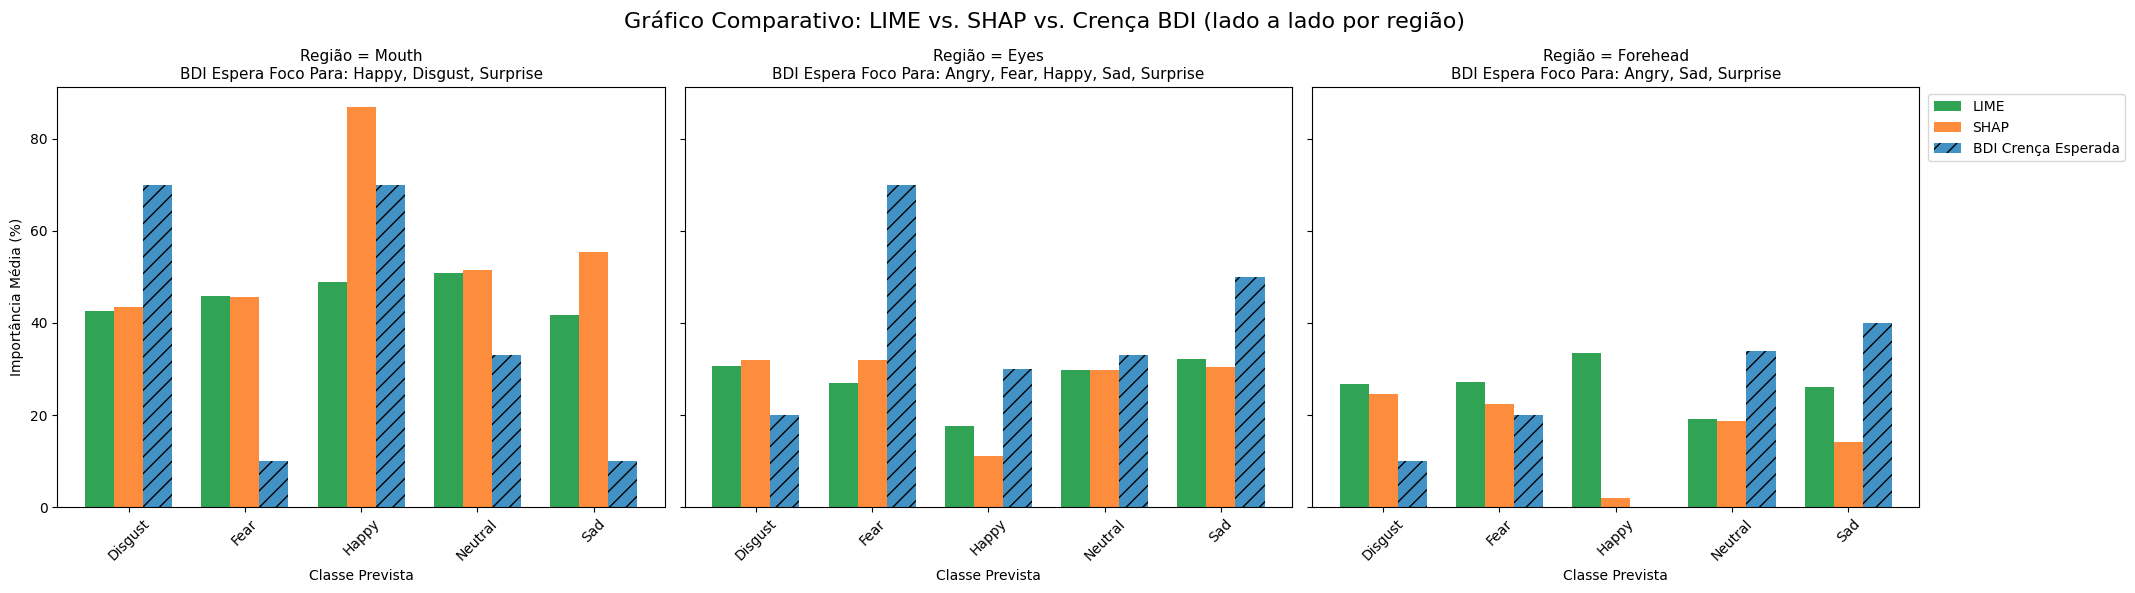

In [30]:
# Gráfico Comparativo Triplo (LIME vs. SHAP vs. BDI)

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

if 'df' not in locals():
    print("ERRO: O DataFrame 'df' (saída do agente BDI) não foi encontrado.")
else:
    print("Gerando gráficos comparativos LIME vs SHAP vs BDI...")

    # 1. Agrupar por classe prevista (já tem todas as colunas de crença)
    df_agg = df.groupby('pred_label_name').mean(numeric_only=True)

    # 2. Criar figura com 3 subplots (um por região)
    fig, axes = plt.subplots(1, 3, figsize=(21, 6), sharey=True)

    regioes = [
        ("Mouth",   ["lime_mouth_pct", "shap_mouth_pct", "crenca_mouth_pct"]),
        ("Eyes",    ["lime_eyes_pct", "shap_eyes_pct", "crenca_eyes_pct"]),
        ("Forehead",["lime_forehead_pct", "shap_forehead_pct", "crenca_forehead_pct"])
    ]

    bdi_titles = {
        'Mouth': 'Happy, Disgust, Surprise',
        'Eyes': 'Angry, Fear, Happy, Sad, Surprise',
        'Forehead': 'Angry, Sad, Surprise'
    }

    width = 0.25  # Largura de cada barra (menor para caber 3)

    for ax, (reg, cols) in zip(axes, regioes):

        # Criar o DataFrame de plotagem com 3 colunas
        plot_df = pd.DataFrame({
            'Classe Prevista': df_agg.index,
            'LIME (%)': df_agg[cols[0]].values * 100,
            'SHAP (%)': df_agg[cols[1]].values * 100,
            'BDI Crença (%)': df_agg[cols[2]].values * 100
        })

        # Posições no eixo X (ex: 0, 1, 2, 3, 4, 5, 6)
        x = np.arange(len(plot_df))

        # Posição 1: x - width
        ax.bar(x - width, plot_df["LIME (%)"], width, label="LIME", color="#31a354")
        # Posição 2: x (centro)
        ax.bar(x,         plot_df["SHAP (%)"], width, label="SHAP", color="#fd8d3c")
        # Posição 3: x + width
        ax.bar(x + width, plot_df["BDI Crença (%)"], width, label="BDI Crença Esperada", color="#4292c6", hatch='//')

        # Configurações
        ax.set_xticks(x)
        ax.set_xticklabels(plot_df["Classe Prevista"], rotation=45)
        ax.set_title(
            f"Região = {reg}\nBDI Espera Foco Para: {bdi_titles[reg]}",
            fontsize=11
        )
        ax.set_xlabel("Classe Prevista")

    axes[0].set_ylabel("Importância Média (%)")
    # Mover a legenda para acomodar a nova entrada
    axes[2].legend(loc='upper right', bbox_to_anchor=(1.35, 1))

    plt.suptitle("Gráfico Comparativo: LIME vs. SHAP vs. Crença BDI (lado a lado por região)", fontsize=16)
    plt.tight_layout()
    plt.show()